# Title: Classifying Explicit Songs on Spotify From 2010-2019 via K-Nearest Neighbors

In [169]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(RColorBrewer)

# 1. Introduction

### In this study, we will study a data set of Top Hit Spotify Songs from 2000-to 2019, originating from Kaggle. 
With the digitization of the music industry and the prevalence of streaming services such as Spotify and Apple music comes an increased reliance on algorithms to improve user experience: assortments of music are clustered into niche genres, dozens of playlists are curated and cultivated for each of its hundreds of millions of user every single day, and every single minute detail of a user’s interaction with its content is tracked in order to predict whether or they’ll like a recommended song. Spotify would not be where it is today without its strong predictive algorithms. However, despite its impressive and at times invasive approach to algorithms, one important aspect of a song’s metrics is notably absent from its classification systems: explicitness. 
   
   Currently, the onus of classifying music as explicit is placed on the rights-holders, or those who upload music to [Spotify](https://support.spotify.com/us/article/explicit-content/) (Spotify, n.d.). However, because a majority of the most popular music on the streaming service is marked as not explicit, rights holders may not actually be incentivised to properly label their music truthly. It appears that when explicit music fails to be flagged on the part of the rights-holders, it is the responsibility of the listeners to notify spotify; at no point is Spotify accountable in ensuring that potentially harmful content doesn't accidentally fall into the ears of those who are not fit to listen to it. As such, it’s rather surprising that a music-streaming service as large and almost ubiquitous as spotify has yet to develop a classification system that automatically flags music as explicit. 
    
    
   Our project plans to fill this very blatant oversight in Spotify’s algorithm by answering the question: is it possible for a song on Spotify to be classified as explicit or non-explicit? To answer this question, we plan to design and implement a k-nearest neighbour classification system with 5-fold cross-validation using the data set [Top Hit Spotify Songs from 2000-to 2019](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019) (see Koverha, 2022), originating from Kaggle. The title is relatively self explanatory as the data looks at the most popular songs released from each year over the course of twenty years. Furthermore, the data is organized into 18 columns, each of which describes the track and its quality. After exploring the data and deciding on adequate predictor variables, we were able to run the algorithm and properly classify whether or not a song was explicit with 82% accuracy, which can goes to show how simple it would be for Spotify to develop an explicitness classification system in order to improve its user experience.



In [170]:
# read + clean + wrangle data ----------------------------------------------------
single_genre <- c('country', 'latin', 'Dance/Electronic', 'Folk/Acoustic',
'pop', 'rock','hip hop','R&B','metal','jazz','blues','classical','World/Traditional')

In [171]:
set.seed(999)
options(repr.plot.width = 8, repr.plot.height = 8)
song <- read_csv('https://raw.githubusercontent.com/nicolelassetter/DSCI100-project-g28/main/songs_normalize.csv') %>%
    mutate(genre <- as_factor(genre))%>%
    filter(genre %in% single_genre)

head(song) 
paste("Table 1. Small Preview of Data Set")

Parsed with column specification:
cols(
  artist = col_character(),
  song = col_character(),
  duration_ms = col_double(),
  explicit = col_logical(),
  year = col_double(),
  popularity = col_double(),
  danceability = col_double(),
  energy = col_double(),
  key = col_double(),
  loudness = col_double(),
  mode = col_double(),
  speechiness = col_double(),
  acousticness = col_double(),
  instrumentalness = col_double(),
  liveness = col_double(),
  valence = col_double(),
  tempo = col_double(),
  genre = col_character()
)



artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,genre <- as_factor(genre)
<chr>,<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
Britney Spears,Oops!...I Did It Again,211160,FALSE,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.30000,1.77e-05,0.3550,0.894,95.053,pop,pop
*NSYNC,Bye Bye Bye,200560,FALSE,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.04080,1.04e-03,0.0845,0.879,172.656,pop,pop
Eminem,The Real Slim Shady,284200,TRUE,2000,86,0.949,0.661,5,-4.244,0,0.0572,0.03020,0.00e+00,0.0454,0.760,104.504,hip hop,hip hop
Modjo,Lady - Hear Me Tonight,307153,FALSE,2001,77,0.720,0.808,6,-5.627,1,0.0379,0.00793,2.93e-02,0.0634,0.869,126.041,Dance/Electronic,Dance/Electronic
Gigi D'Agostino,L'Amour Toujours,238759,FALSE,2011,1,0.617,0.728,7,-7.932,1,0.0292,0.03280,4.82e-02,0.3600,0.808,139.066,pop,pop
Eiffel 65,Move Your Body - Gabry Ponte Original Radio Edit,268863,FALSE,1999,56,0.745,0.958,7,-9.664,1,0.0287,0.08130,3.24e-01,0.5330,0.960,129.962,pop,pop


[1] "Table 1. Small Preview of Data Set"

In [172]:
# count the row of missing data to see if we need to tidy our data, and the result is zero.
zero <- sum(anyNA(song))

# Table1 : count how many explicit vs non-explict are present to see if we need to balance the data prior training to avoid bias
n_explicit <- song %>%
    group_by(explicit) %>%
    summarize(n = n()) %>%
    mutate(percent = 100*n/nrow(song))

n_explicit
paste('Table 2: How Many in Count and Percentage of Explicit vs Non-Explicit Songs Present in Entire Dataset')
paste('The data is still consider balance (74% non-explicit, and 26% explicit), no balancing is required.')

`summarise()` ungrouping output (override with `.groups` argument)


explicit,n,percent
<lgl>,<int>,<dbl>
FALSE,516,73.9255
TRUE,182,26.0745


[1] "Table 2: How Many in Count and Percentage of Explicit vs Non-Explicit Songs Present in Entire Dataset"

[1] "The data is still consider balance (74% non-explicit, and 26% explicit), no balancing is required."

We split our data set so that 75% of the original data set ends up in the training set, and 25% would be in the test set(using the function initial_split). To increase the readability of the 18 columns, we wil only keep the classifier and the predictors.

In [173]:
set.seed(999)
# split data to Training + Testing Data ---------------------------------------------
song_split <- initial_split(song, prop = 0.75, strata = explicit)
song_train <- training(song_split)
track_test <- testing(song_split)

In [174]:
#summarize the whole training data
summary(song_train)
paste('Table 3: Statistical Summaries of the Entire Training Data')

    artist              song            duration_ms      explicit      
 Length:524         Length:524         Min.   :119133   Mode :logical  
 Class :character   Class :character   1st Qu.:202123   FALSE:387      
 Mode  :character   Mode  :character   Median :219773   TRUE :137      
                                       Mean   :226304                  
                                       3rd Qu.:244383                  
                                       Max.   :452906                  
                                                                       
      year        popularity     danceability        energy      
 Min.   :1999   Min.   : 0.00   Min.   :0.1290   Min.   :0.0549  
 1st Qu.:2005   1st Qu.:57.00   1st Qu.:0.5627   1st Qu.:0.6388  
 Median :2010   Median :67.00   Median :0.6560   Median :0.7395  
 Mean   :2010   Mean   :60.49   Mean   :0.6489   Mean   :0.7249  
 3rd Qu.:2015   3rd Qu.:75.00   3rd Qu.:0.7482   3rd Qu.:0.8430  
 Max.   :2020   Max.   :88.0

[1] "Table 3: Statistical Summaries of the Entire Training Data"

In [175]:
# summarise only training data info into tables ----------------------------------------
mean_table_training <- song_train %>%
    select(speechiness, energy, danceability) %>%
    map_df(mean)

mean_table_training
paste('Table 4. Arithmetic Means of Speechiness, Energy, and Danceability Values of the Training Data')

speechiness,energy,danceability
<dbl>,<dbl>,<dbl>
0.09685267,0.7249218,0.6489008


[1] "Table 4. Arithmetic Means of Speechiness, Energy, and Danceability Values of the Training Data"

# 2. Methods

For the sake of the project, we will only use songs with a single genre. 

Data analysis will be conducted on Jupyter notebook using R. We will use the tidyverse, repr, dplyr, RColorBrewer and themis libraries as they contain the functions required for our calculations and visualizations. Our primary method is classification using K-nearest neighbours (KNN). We mostly based our model from [Data Science: A First Introduction](https://datasciencebook.ca/) (Timbers et al., 2022) and accessed our data from Kaggle (Koverha, 2022). To begin, we will create a training and test data set and use only the training data for the preprocessing/preliminary steps.



Hence, the remaining columns from the data set are as follows:

1. *explicit*: The song or music video contains content that is considered offensive or inappropriate for children.
2. *speechiness*: Measure from 0.0 to 1.0 of the presence of spoken words. The closer the song is near 1.0, the more words has.
3. *energy*: Measure from 0.0 to 1.0, a perceptual measure of intensity and activity.
4. *danceability*: How suitable the track is for dancing based on tempo, rhythm stability, beat strength, and overall regularity. 0 = least danceable, 1.0 = most danceable.
5. *genre* : Track’s genre.



# To Begin:

The genre is plotted into bar graphs to visualize the genre distribution of our training data. Next, scatter plots are used to determine the predictors by looking for relationships. The following step is plotting numerous graphs using our training data with explicit as our classifier to discover relationships. We found that speechiness, energy, danceability and genre had a sort of linear or grouped relationship to explicitness through plotting, and the others did not have a relation. However, genre was not used as a predictor because it consist of categorical value - which does not have a distance metric that is suitable a KNN classification.

In [176]:
## Plots that shows little to no relationship to explicitness, put here to show that we did all the exploration, but since there are 
## too many graphs, we did not show all of them.
p00 <- ggplot(song_train,aes(x = popularity,color = explicit))+geom_bar()+scale_fill_brewer(palette = "Set1")
p01 <- ggplot(song_train,aes(x = year,color = explicit))+geom_bar()+scale_fill_brewer(palette = "Set1")
p02 <- ggplot(song_train,aes(x = energy ,color = explicit))+geom_bar()+scale_fill_brewer(palette = "Set1")
p03 <- ggplot(song_train,aes(x = loudness,color = explicit))+geom_bar()+scale_fill_brewer(palette = "Set1")
p04 <- ggplot(song_train,aes(x = mode ,color = explicit))+geom_bar()+scale_fill_brewer(palette = "Set1")
p05 <- ggplot(song_train,aes(x = valence ,color = explicit))+geom_histogram()
p06 <- ggplot(song_train,aes(x = danceability ,color = explicit))+geom_histogram()
p07 <- ggplot(song_train,aes(x = popularity ,color = explicit))+geom_histogram()
p08 <- ggplot(song_train,aes(x = key ,color = explicit))+geom_histogram()
p09 <- ggplot(song_train,aes(x = loudness ,color = explicit))+geom_histogram()
p10 <- ggplot(song_train,aes(x = acousticness ,color = explicit))+geom_histogram()
p11 <- ggplot(song_train,aes(x = instrumentalness ,color = explicit))+geom_histogram()
p12 <- ggplot(song_train,aes(x = liveness ,color = explicit))+geom_histogram()
p13 <- ggplot(song_train,aes(x = valence ,color = explicit))+geom_histogram()
p14 <- ggplot(song_train,aes(x = tempo ,color = explicit))+geom_histogram()
p15 <- ggplot(song_train,aes(x = genre ,color = explicit))+geom_bar()

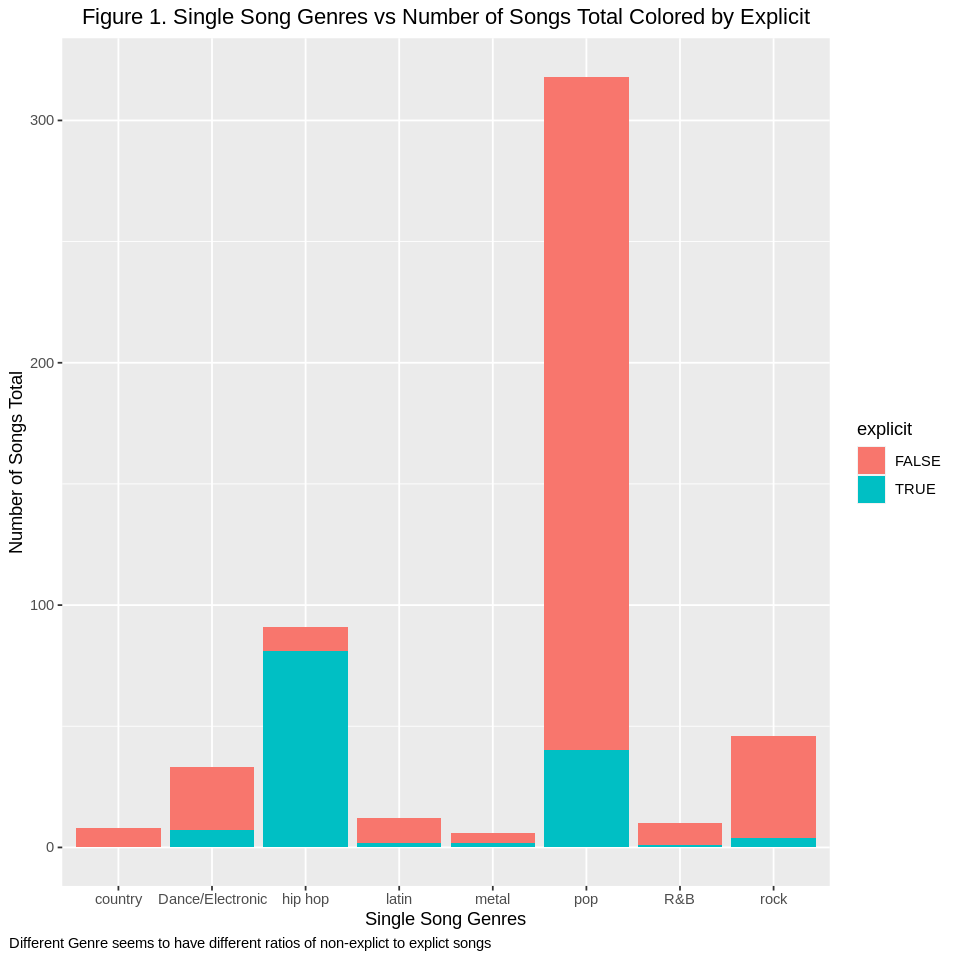

In [177]:
# Using training data: visualise data to find possible predictors relevant for analysis ----
options(repr.plot.width = 8, repr.plot.height = 8)


# Bar: genre vs count (Number of Songs Total)

plot1 <- n_genre_table_training %>%
    ggplot(aes(x = genre, fill = explicit, y = n)) +
    geom_bar(stat = 'identity') +
    labs(x = "Single Song Genres", y = 'Number of Songs Total') +
    ggtitle('Figure 1. Single Song Genres vs Number of Songs Total Colored by Explicit') +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(plot.caption.position = "plot", plot.caption = element_text(hjust = 0)) +
    labs(caption = "Different Genre seems to have different ratios of non-explict to explict songs")

plot1

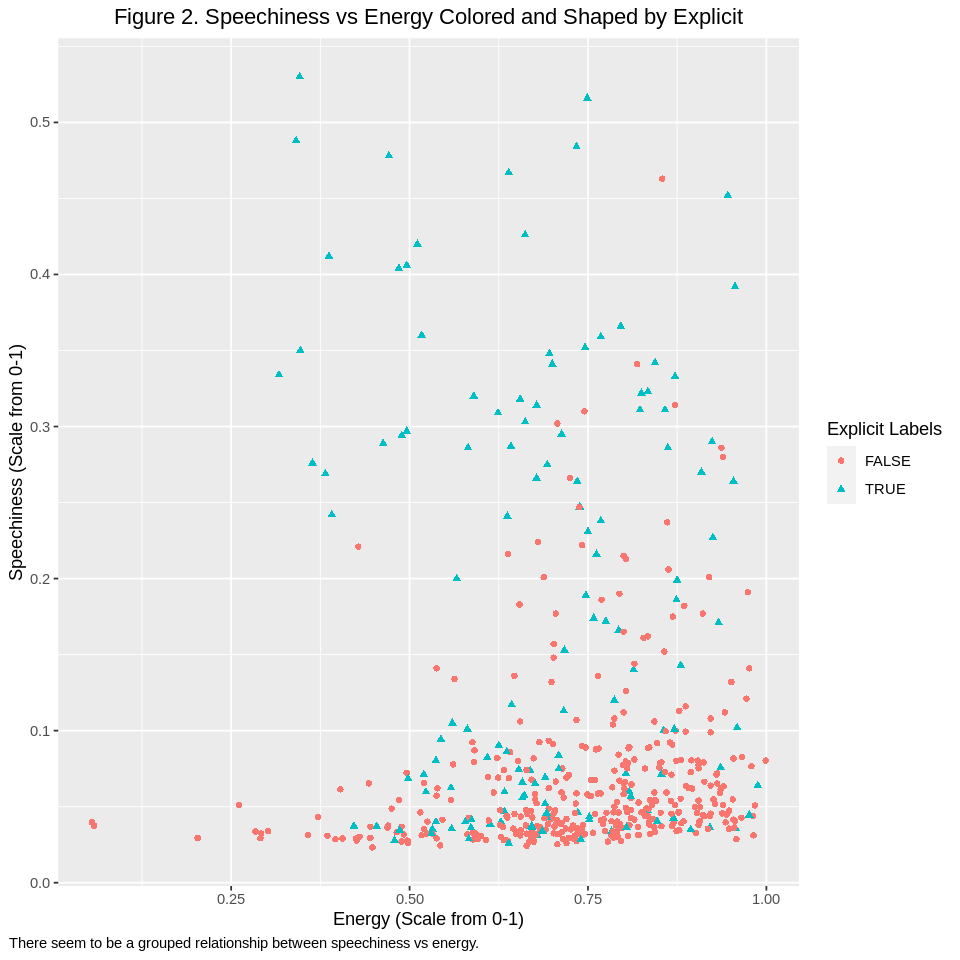

In [178]:
# Scatter: Speechiness vs Energy Colored and Shaped by Explicit
plot2 <- song_train %>%
    ggplot(aes(x = energy, y = speechiness, colour = explicit, shape = explicit)) +
    geom_point() +
    labs(x = "Energy (Scale from 0-1)", y = 'Speechiness (Scale from 0-1)', shape = "Explicit Labels", color = "Explicit Labels") +
    ggtitle('Figure 2. Speechiness vs Energy Colored and Shaped by Explicit') +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(plot.caption.position = "plot", plot.caption = element_text(hjust = 0)) +
    labs(caption = "There seem to be a grouped relationship between speechiness vs energy.")
plot2

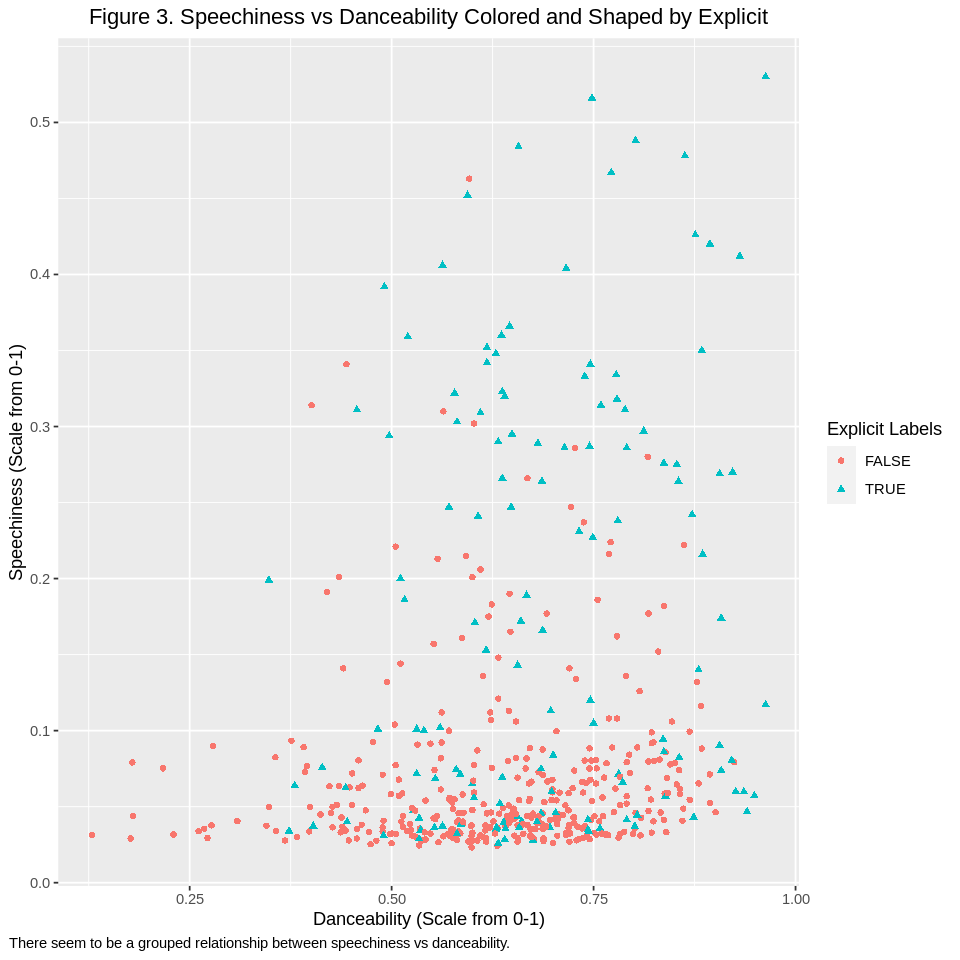

In [179]:
# Scatter: Speechiness vs Danceability Colored and Shaped by Explicit
plot3 <- song_train %>%
    ggplot(aes(x = danceability, y = speechiness, colour = explicit, shape = explicit)) +
    geom_point() +
    labs(x = "Danceability (Scale from 0-1)", y = 'Speechiness (Scale from 0-1)', shape = "Explicit Labels", color = "Explicit Labels") +
    ggtitle('Figure 3. Speechiness vs Danceability Colored and Shaped by Explicit') +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(plot.caption.position = "plot", plot.caption = element_text(hjust = 0)) +
    labs(caption = "There seem to be a grouped relationship between speechiness vs danceability.") 
plot3

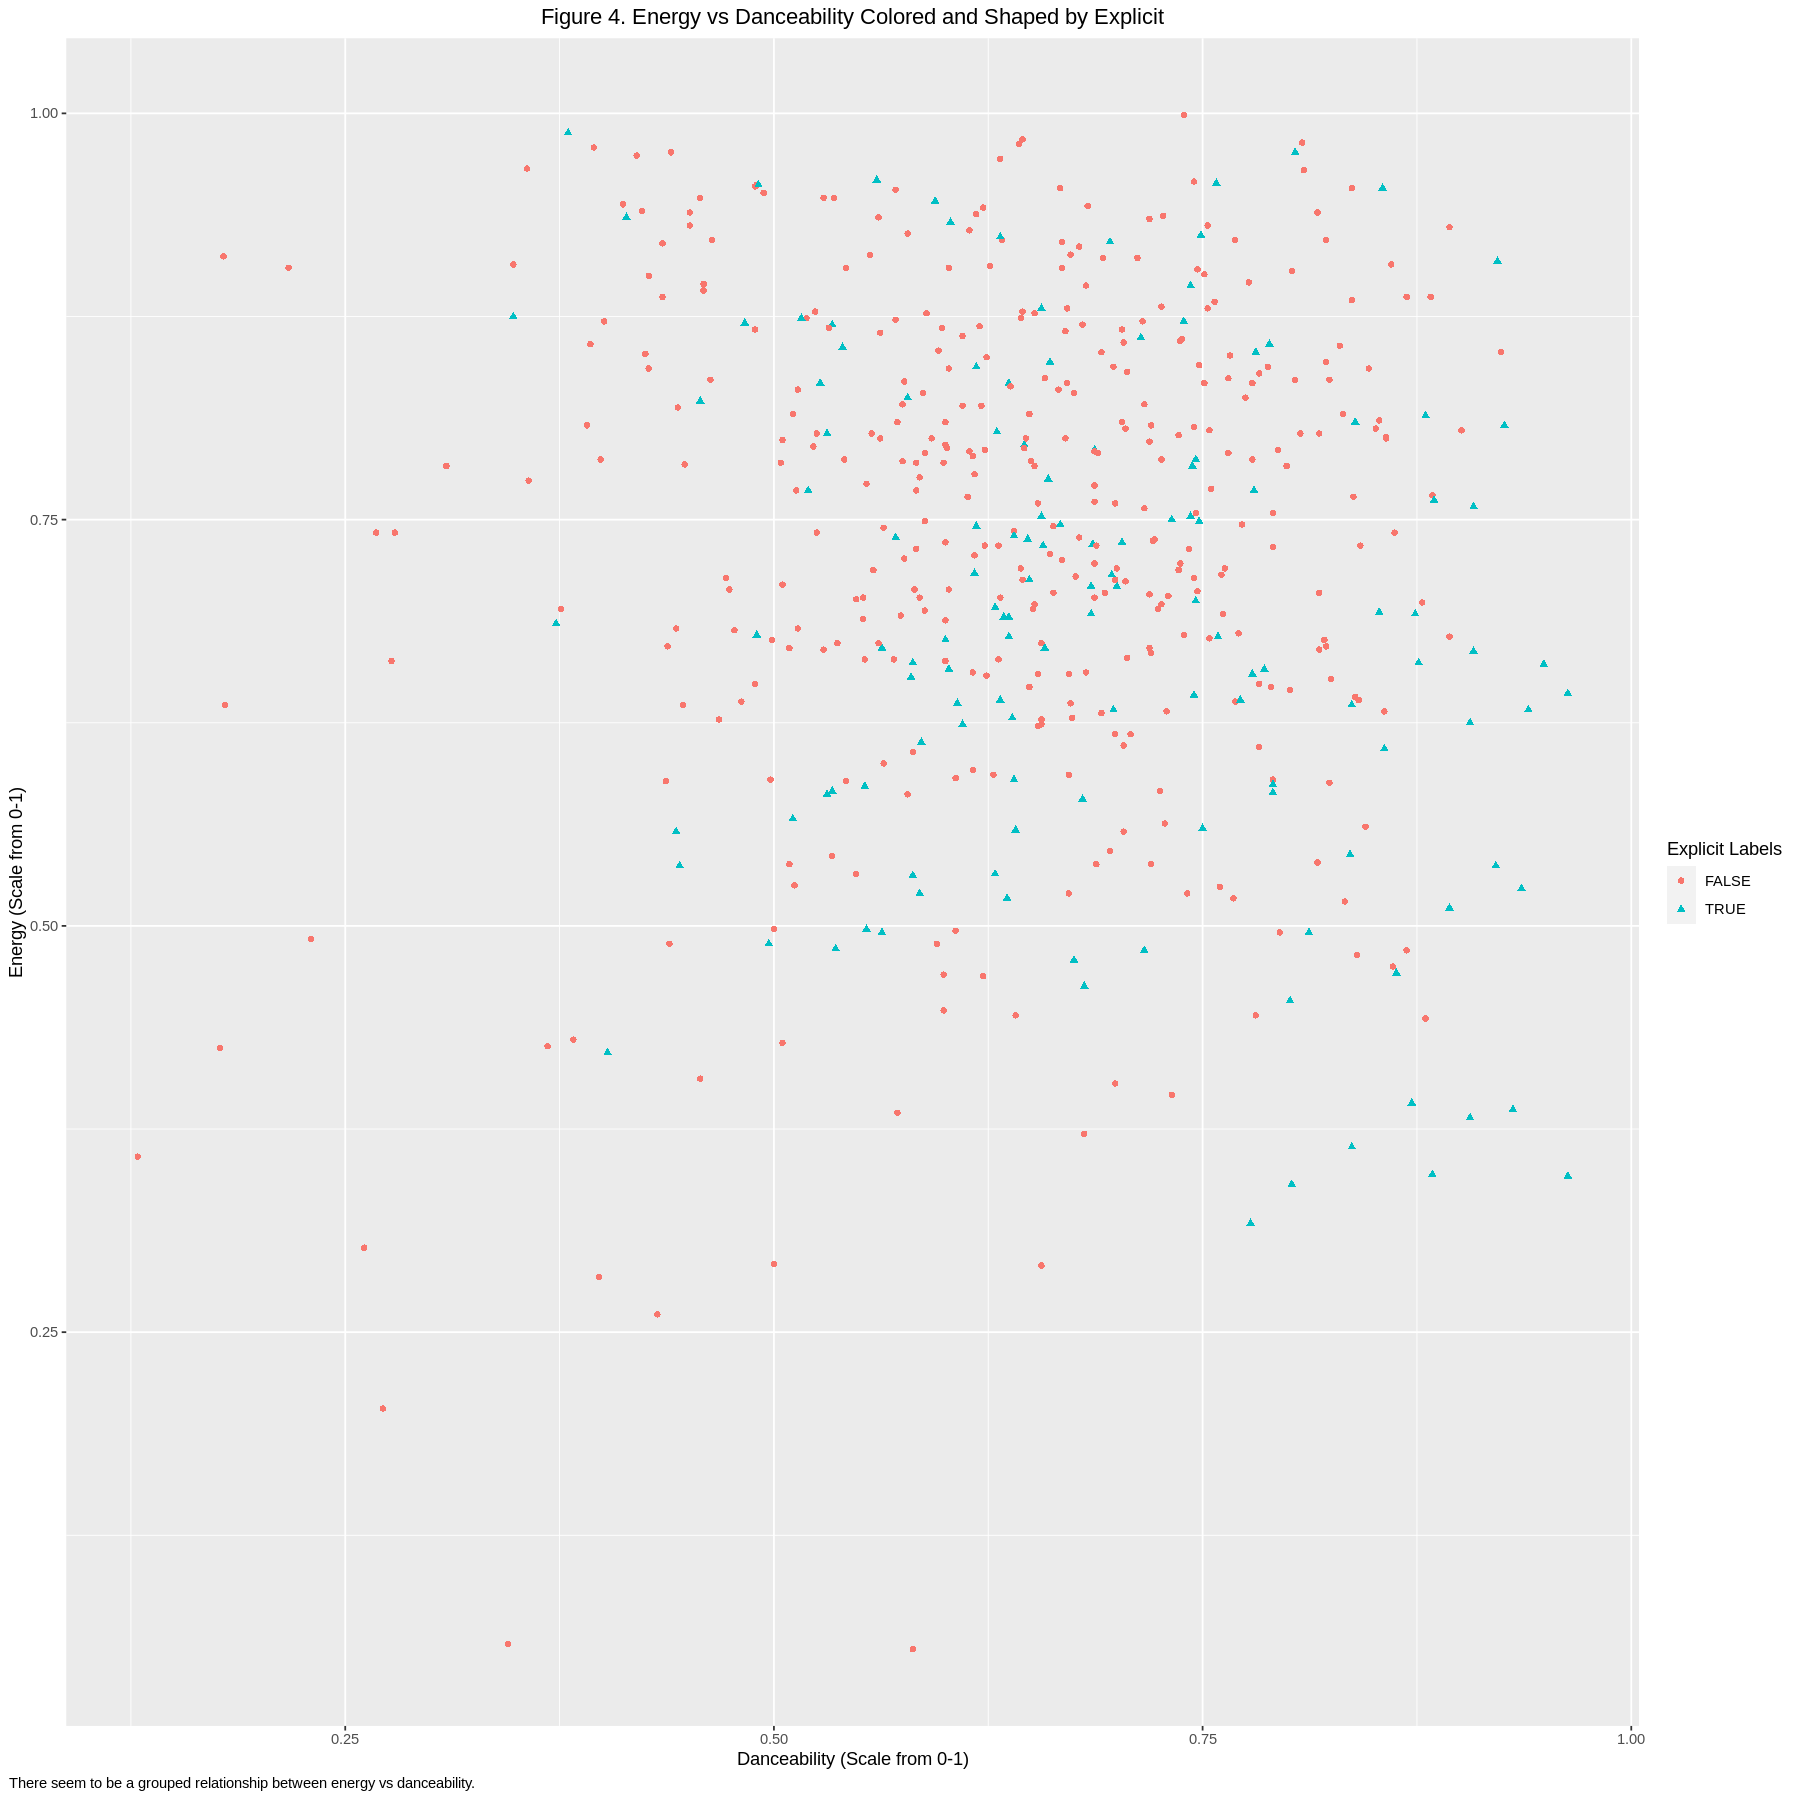

In [198]:
# Scatter : Energy vs Danceability Colored and Shaped by Explicit
plot4 <- song_train %>%
    ggplot(aes(x = danceability, y = energy, colour = explicit, shape = explicit)) +
    geom_point() +
    labs(x = "Danceability (Scale from 0-1)", y = 'Energy (Scale from 0-1)', shape = "Explicit Labels", color = "Explicit Labels") +
    ggtitle('Figure 4. Energy vs Danceability Colored and Shaped by Explicit') +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(plot.caption.position = "plot", plot.caption = element_text(hjust = 0)) +
    labs(caption = "There seem to be a grouped relationship between energy vs danceability.")
plot4

### Modeling

The first step of this analysis is selecting the optimal K value for our K-nearest-neighbours (KNN) calculations. Analysis begins with performing a cross-validation calculation using vfold, where the overall training data is split into C evenly sized chunks in order to perform a 5-fold cross-validation. Then cross-validation is run on each train/validation split. This reduces the influence of any one (un)lucky validation set on the estimate. The steps follow below.


In [181]:
set.seed(999)
# Perform the data analysis -----------------------------------------------------------------------------------

# select only the columns that contains the response variable + predictors we will use
songs <- song %>%
    select(explicit, speechiness, danceability, energy) %>%
    mutate(explicit = as_factor(explicit))

# split data to Training + Testing data 
songs_split <- initial_split(songs, prop = 0.75, strata = explicit)
songs_train <- training(songs_split)
tracks_test <- testing(songs_split)

Here, we create a recipe that specifies our class label (explicit) and our predictors (the rest of our predictors). We use our training data, as we don't want our testing data to "see light" yet. We also perform the preprocessing steps, passing the training data as the data argument in the recipe. Because we are looking for K, we say neighbors = tune() instead of a number value. This includes scaling all predictors (step_scale and step_center) to ensure they have a mean of 0 and a standard deviation of 1.

In [182]:
set.seed(999)

songs_recipe <- recipe(explicit ~ speechiness + danceability + energy, data = songs_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

 
We then add the recipe and model specification to a workflow and use the tune_grid function to estimate the classifier’s accuracy over the training/validation splits. Collect_metrics is used to aggregate the mean and standard error of the classifier’s validation accuracy across the folds.


In [183]:
set.seed(999)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

songs_vfold <- vfold_cv(songs_train, v = 5, strata = explicit)
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() %>%
    add_recipe(songs_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = songs_vfold, grid = k_vals) %>%
    collect_metrics()

Our classifier training and cross-validation is now complete! Now, we plot our filtered knn_results to visualize the accuracy across different values of K. The K value we chose is K= because from the plot, we can see this has the highest accuracy and does not change much when we change K to a nearby value.

In [184]:
set.seed(999)

accuracies <- knn_results %>%
     filter(.metric == 'accuracy')

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = 'Neighbors', y = 'Accuracy Estimate') +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = seq(0, 30)) +
    ggtitle( "Figure 5. Estimated Accuracy vs Neighbors") +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(plot.caption.position = "plot", plot.caption = element_text(hjust = 0)) +
    labs(caption = "From K values from 1 to 10, K = 10 seems to have the highest estimated accuracy.")


In [185]:
print(accuracies)
paste("Table 5. Statistical Information on The Estimate Accuracy of The Classifier Over the Training/Validation Splits")

# A tibble: 10 × 7
   neighbors .metric  .estimator  mean     n std_err .config
       <dbl> <chr>    <chr>      <dbl> <int>   <dbl> <chr>  
 1         1 accuracy binary     0.763     5 0.0149  Model01
 2         2 accuracy binary     0.763     5 0.0149  Model02
 3         3 accuracy binary     0.796     5 0.00947 Model03
 4         4 accuracy binary     0.796     5 0.00947 Model04
 5         5 accuracy binary     0.807     5 0.0123  Model05
 6         6 accuracy binary     0.807     5 0.0123  Model06
 7         7 accuracy binary     0.809     5 0.0116  Model07
 8         8 accuracy binary     0.809     5 0.0116  Model08
 9         9 accuracy binary     0.817     5 0.0113  Model09
10        10 accuracy binary     0.817     5 0.0113  Model10


[1] "Table 5. Statistical Information on The Estimate Accuracy of The Classifier Over the Training/Validation Splits"

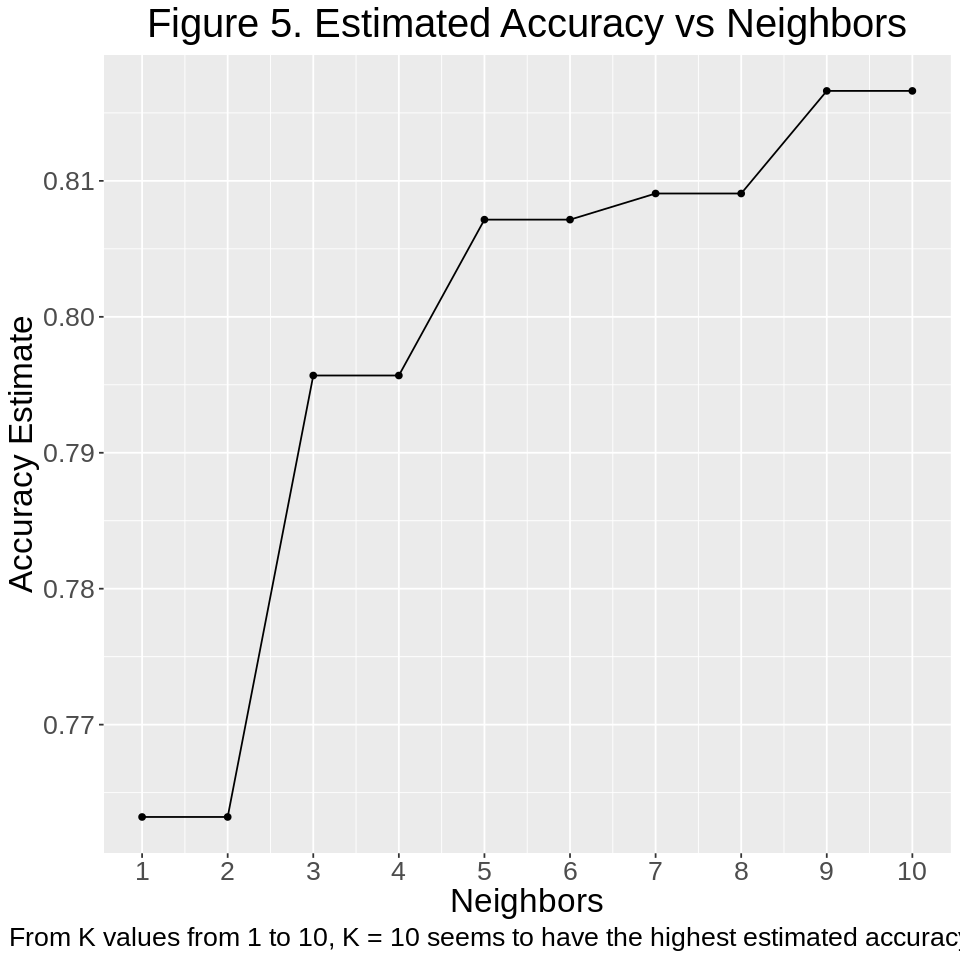

In [186]:
print(cross_val_plot)

Here, a new model specification is made for our chosen K = 10 and the classifier is retrained using the fit function.

In [187]:
# build/train the model 
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) %>%
    set_engine("kknn") %>%
    set_mode("classification")

songs_fit <- workflow() %>%
             add_recipe(songs_recipe) %>%
             add_model(knn_spec_2) %>%
            fit(data = tracks_test)


# Results

 
Finally, we evaluate the estimated accuracy and predict with our test data. Below are the visualizations of the performed analysis. The first is a plot of the confusion matrix distributions as a bar graph. The second is a graph summarizing the data analysis findings. The third group of graphs compare different variables shaped by Explicit with actual and predicted graphs side by side.


In [188]:
# predict the model accuracy
songs_predictions <- predict(songs_fit, tracks_test) %>%
                        bind_cols(tracks_test)

accuracy_on_test <- songs_predictions %>% 
                        metrics(truth = explicit, estimate = .pred_class) %>%
                        filter(.metric == "accuracy")



In [189]:
print('Table 6: Statistics Information About The Accuracy of the Classfier on Testing Set')
accuracy_on_test

[1] "Table 6: Statistics Information About The Accuracy of the Classfier on Testing Set"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8218391


In [190]:
# confusion matrix 
songs_conf_mat <- songs_predictions %>%
                        conf_mat(truth = explicit, estimate = .pred_class) 


In [191]:
paste('Table7: Confusion Matrix of The Classifier on the Testing Set')
songs_conf_mat

[1] "Table7: Confusion Matrix of The Classifier on the Testing Set"

          Truth
Prediction FALSE TRUE
     FALSE   120   22
     TRUE      9   23

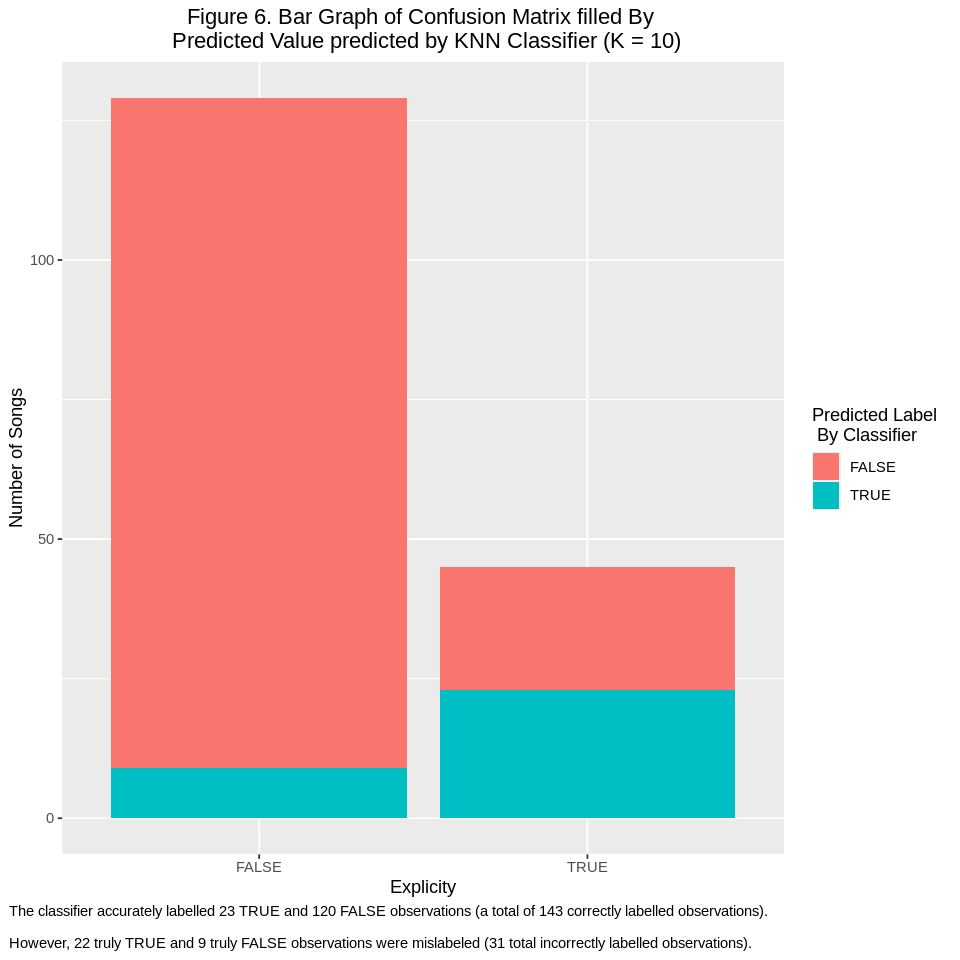

In [165]:
# visualization of the analysis ----------------------------------------------------------------------------

#bar graph of confusion matrix

mat_graph <- songs_predictions %>%
    group_by(explicit)%>%
    ggplot(aes(x = explicit, fill = .pred_class))+
    geom_bar()+
    labs(x = "Explicity", y = 'Number of Songs', fill = "Predicted Label \n By Classifier" ) +
    ggtitle('Figure 6. Bar Graph of Confusion Matrix filled By \n Predicted Value predicted by KNN Classifier (K = 10)') +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(plot.caption.position = "plot", plot.caption = element_text(hjust = 0)) +
    labs(caption = "The classifier accurately labelled 23 TRUE and 120 FALSE observations (a total of 143 correctly labelled observations). \n 
However, 22 truly TRUE and 9 truly FALSE observations were mislabeled (31 total incorrectly labelled observations). ") 
mat_graph


In [127]:
# Table with best K, variables, accuracy
summary_of_analysis = matrix(c('Explicit', 'Speechiness, danceability, energy', 'K = 10', '81.7 %'), ncol = 1, byrow = TRUE) 

rownames(summary_of_analysis) <- c('Response variable', 'Predictors used', 'Optimal K', "Classifier's estimated accuracy on test data")
colnames(summary_of_analysis) <- c('Findings')

analysis <- as.data.frame(summary_of_analysis) 

analysis
paste('Table 7. Summary of the Main Findings of The Classifier')


,Findings
,<chr>
Response variable,Explicit
Predictors used,"Speechiness, danceability, energy"
Optimal K,K = 10
Classifier's estimated accuracy on test data,81.7 %


[1] "Table 7. Summary of the Main Findings of The Classifier"

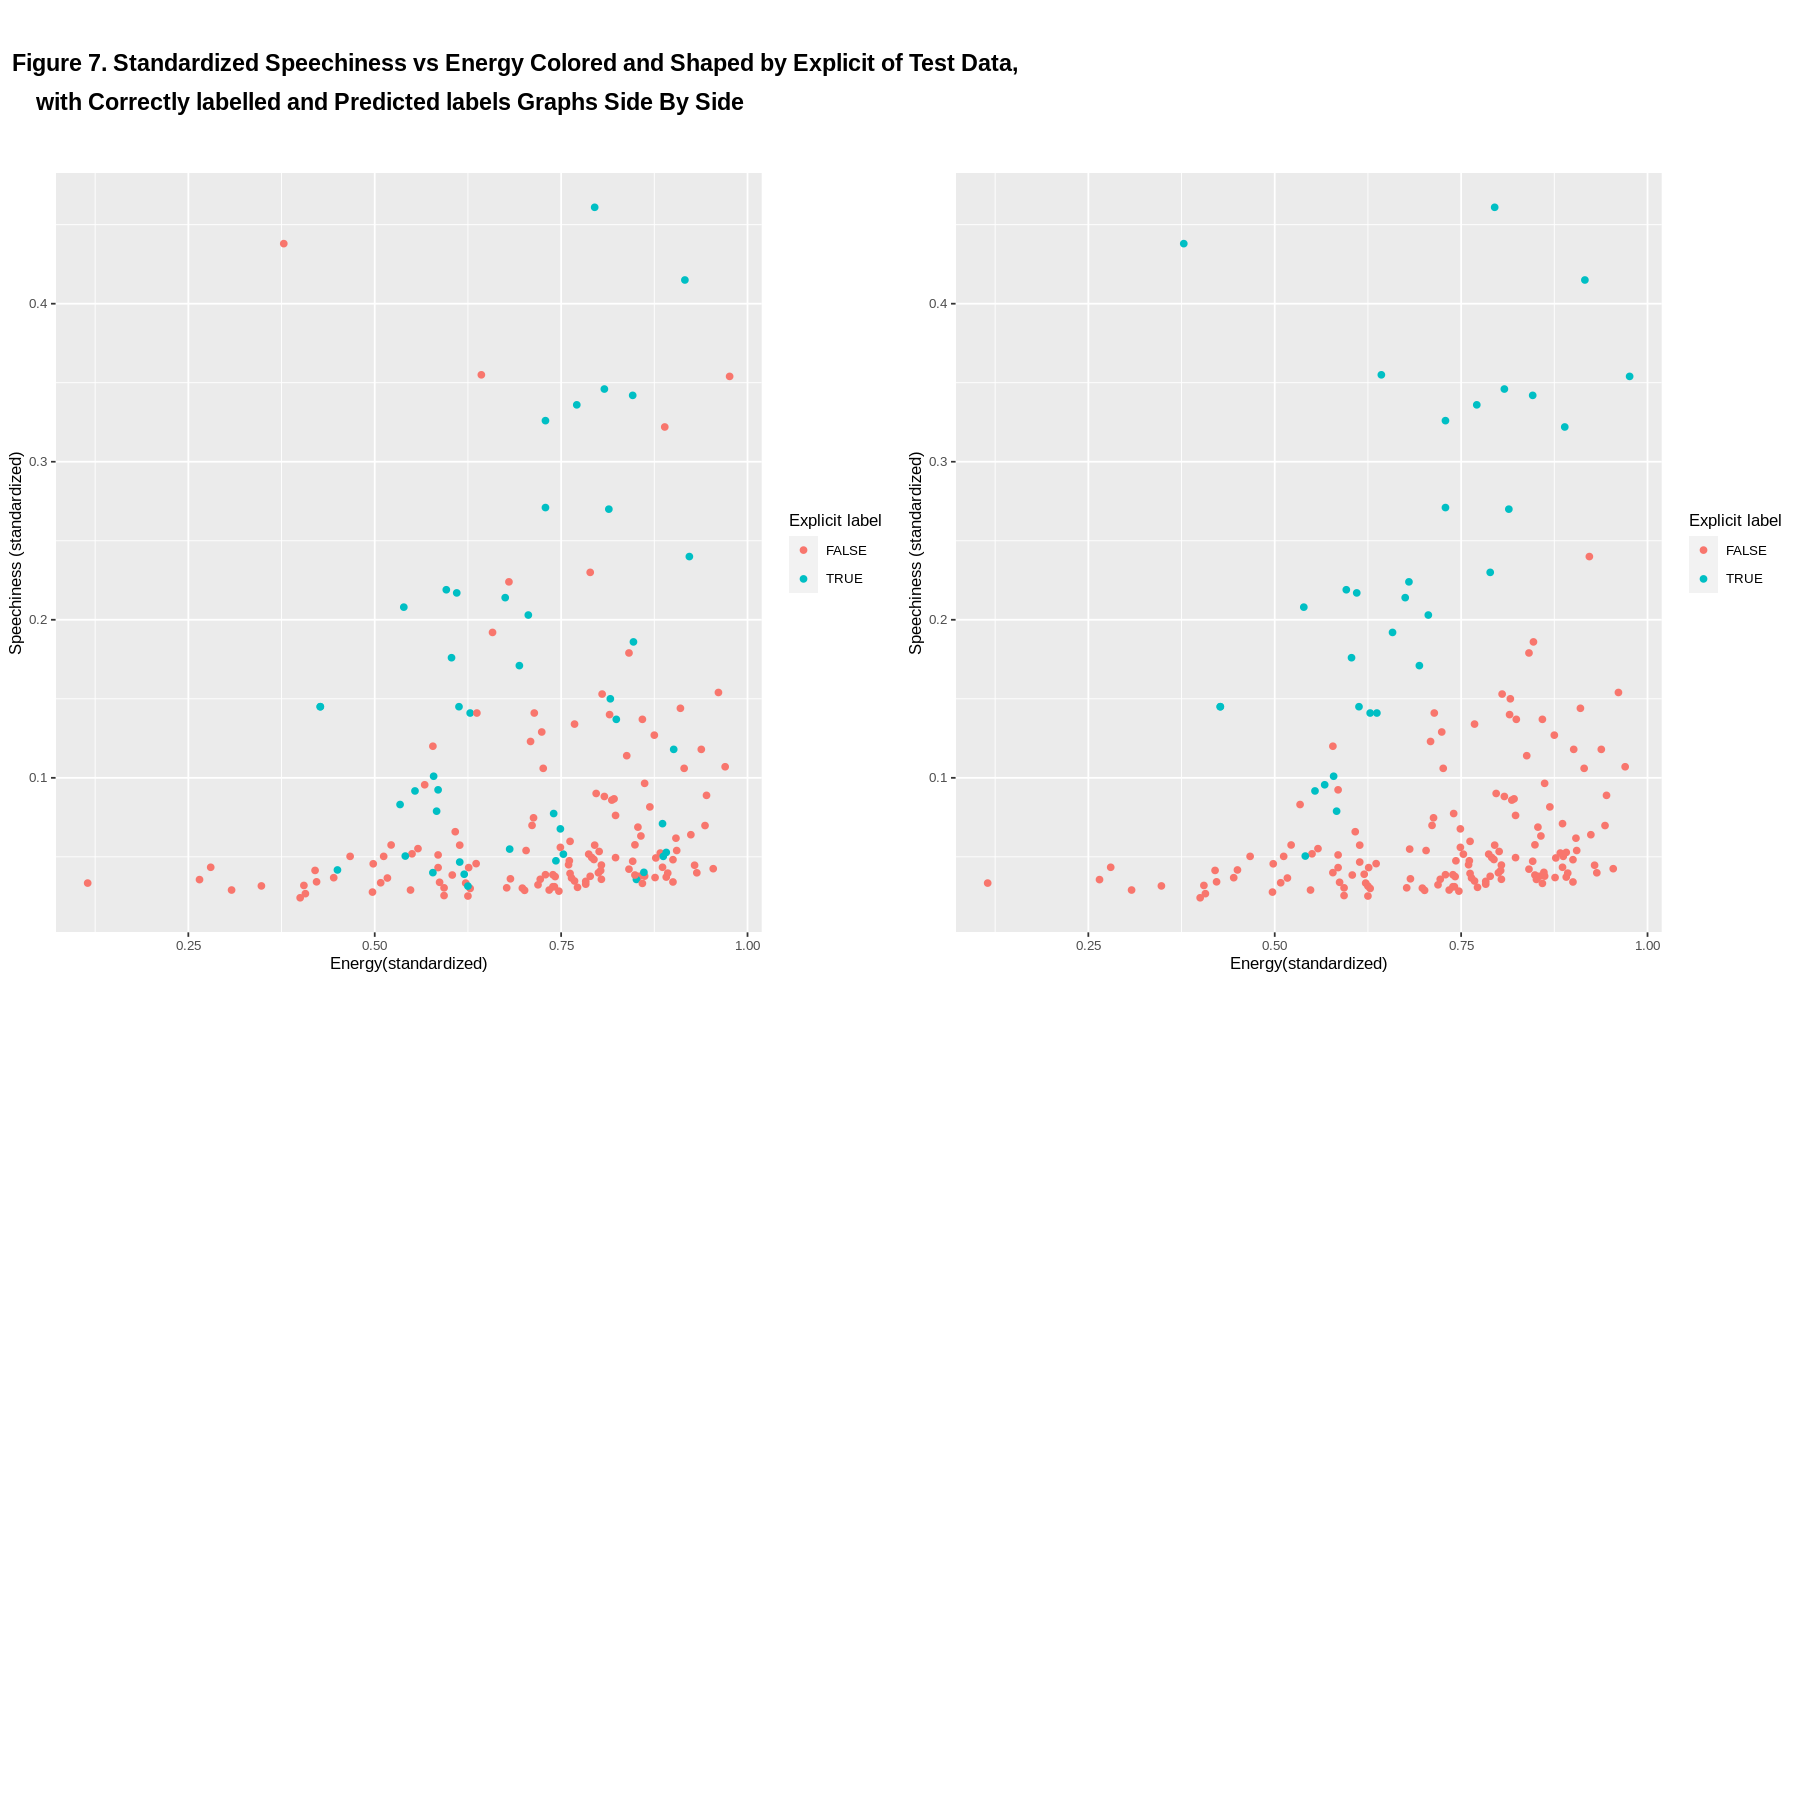

In [194]:
options(repr.plot.width = 15, repr.plot.height = 15)

# Standardized Speechiness vs Energy Colored and Shaped by Explicit with Actual and Predicted Graphs Side By Side

correct_E_vs_S_plot <- ggplot(songs_predictions, aes(x = energy, y = speechiness, color = explicit)) +
                  geom_point() +
                  labs(x = 'Energy(standardized)', y = 'Speechiness (standardized)', color = 'Explicit label') +
                  theme(text = element_text(size = 10)) 

predict_E_vs_S_plot <- ggplot(songs_predictions, aes(x = energy, y = speechiness, color = .pred_class)) +
                  geom_point() +
                  labs(x = 'Energy(standardized)', y = 'Speechiness (standardized)', color = 'Explicit label') +
                  theme(text = element_text(size = 10)) 

E_vs_S_plot <- plot_grid(correct_E_vs_S_plot, predict_E_vs_S_plot, ncol = 2, NULL)

E_vs_S_title <- ggdraw() + 
    draw_label("Figure 7. Standardized Speechiness vs Energy Colored and Shaped by Explicit of Test Data, \n 
    with Correctly labelled and Predicted labels Graphs Side By Side",
    fontface = 'bold', x = 0, hjust = 0, size = 14, lineheight = 0.7) +
    theme(plot.margin = margin(0, 0, 0, 7)) 

E_vs_S_plots <- plot_grid(E_vs_S_title, E_vs_S_plot, ncol = 1,rel_heights = c(0.1, 1)) 

E_vs_S_plots

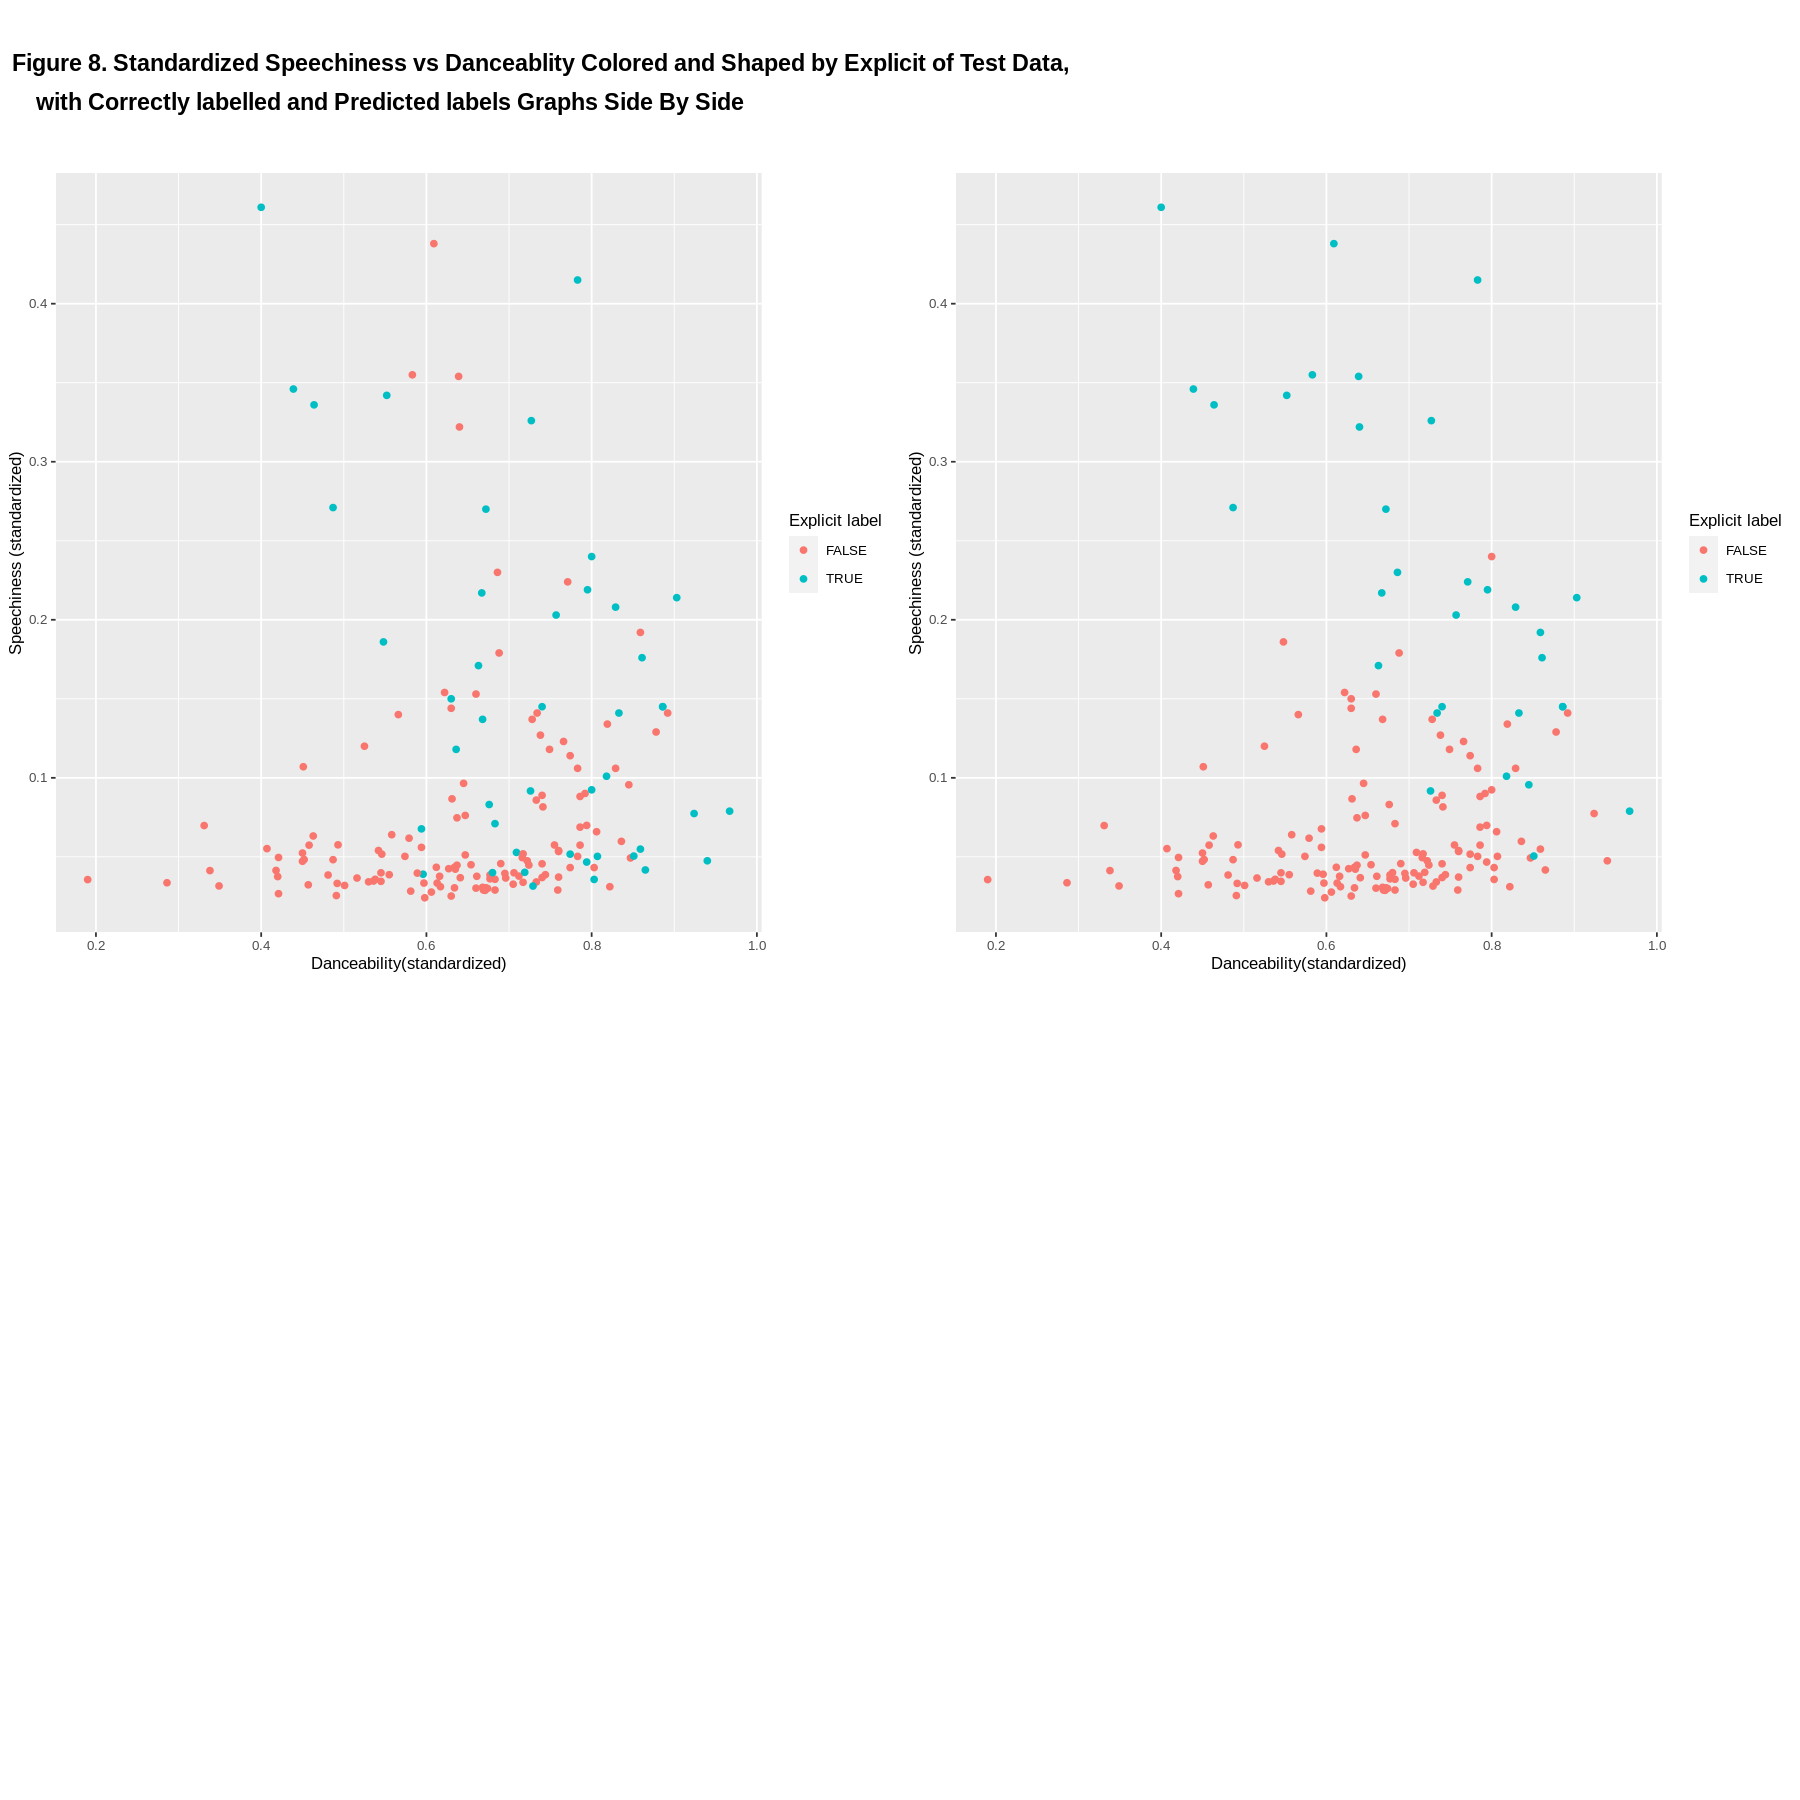

In [195]:
# Standardized Speechiness vs Danceablity Colored and Shaped by Explicit with Actual and Predicted Graphs Side By Side

correct_D_vs_S_plot <- ggplot(songs_predictions, aes(x = danceability, y = speechiness, color = explicit)) +
                  geom_point() +
                  labs(x = 'Danceability(standardized)', y = 'Speechiness (standardized)', color = 'Explicit label') +
                  theme(text = element_text(size = 10)) 

predict_D_vs_S_plot <- ggplot(songs_predictions, aes(x = danceability, y = speechiness, color = .pred_class)) +
                  geom_point() +
                  labs(x = 'Danceability(standardized)', y = 'Speechiness (standardized)', color = 'Explicit label') +
                  theme(text = element_text(size = 10)) 

D_vs_S_plot <- plot_grid(correct_D_vs_S_plot, predict_D_vs_S_plot, ncol = 2, NULL)

D_vs_S_title <- ggdraw() + 
    draw_label("Figure 8. Standardized Speechiness vs Danceablity Colored and Shaped by Explicit of Test Data, \n 
    with Correctly labelled and Predicted labels Graphs Side By Side",
    fontface = 'bold', x = 0, hjust = 0, size = 14, lineheight = 0.7) +
    theme(plot.margin = margin(0, 0, 0, 7))

D_vs_S_plots <- plot_grid(D_vs_S_title, D_vs_S_plot, ncol = 1,rel_heights = c(0.1, 1))

D_vs_S_plots


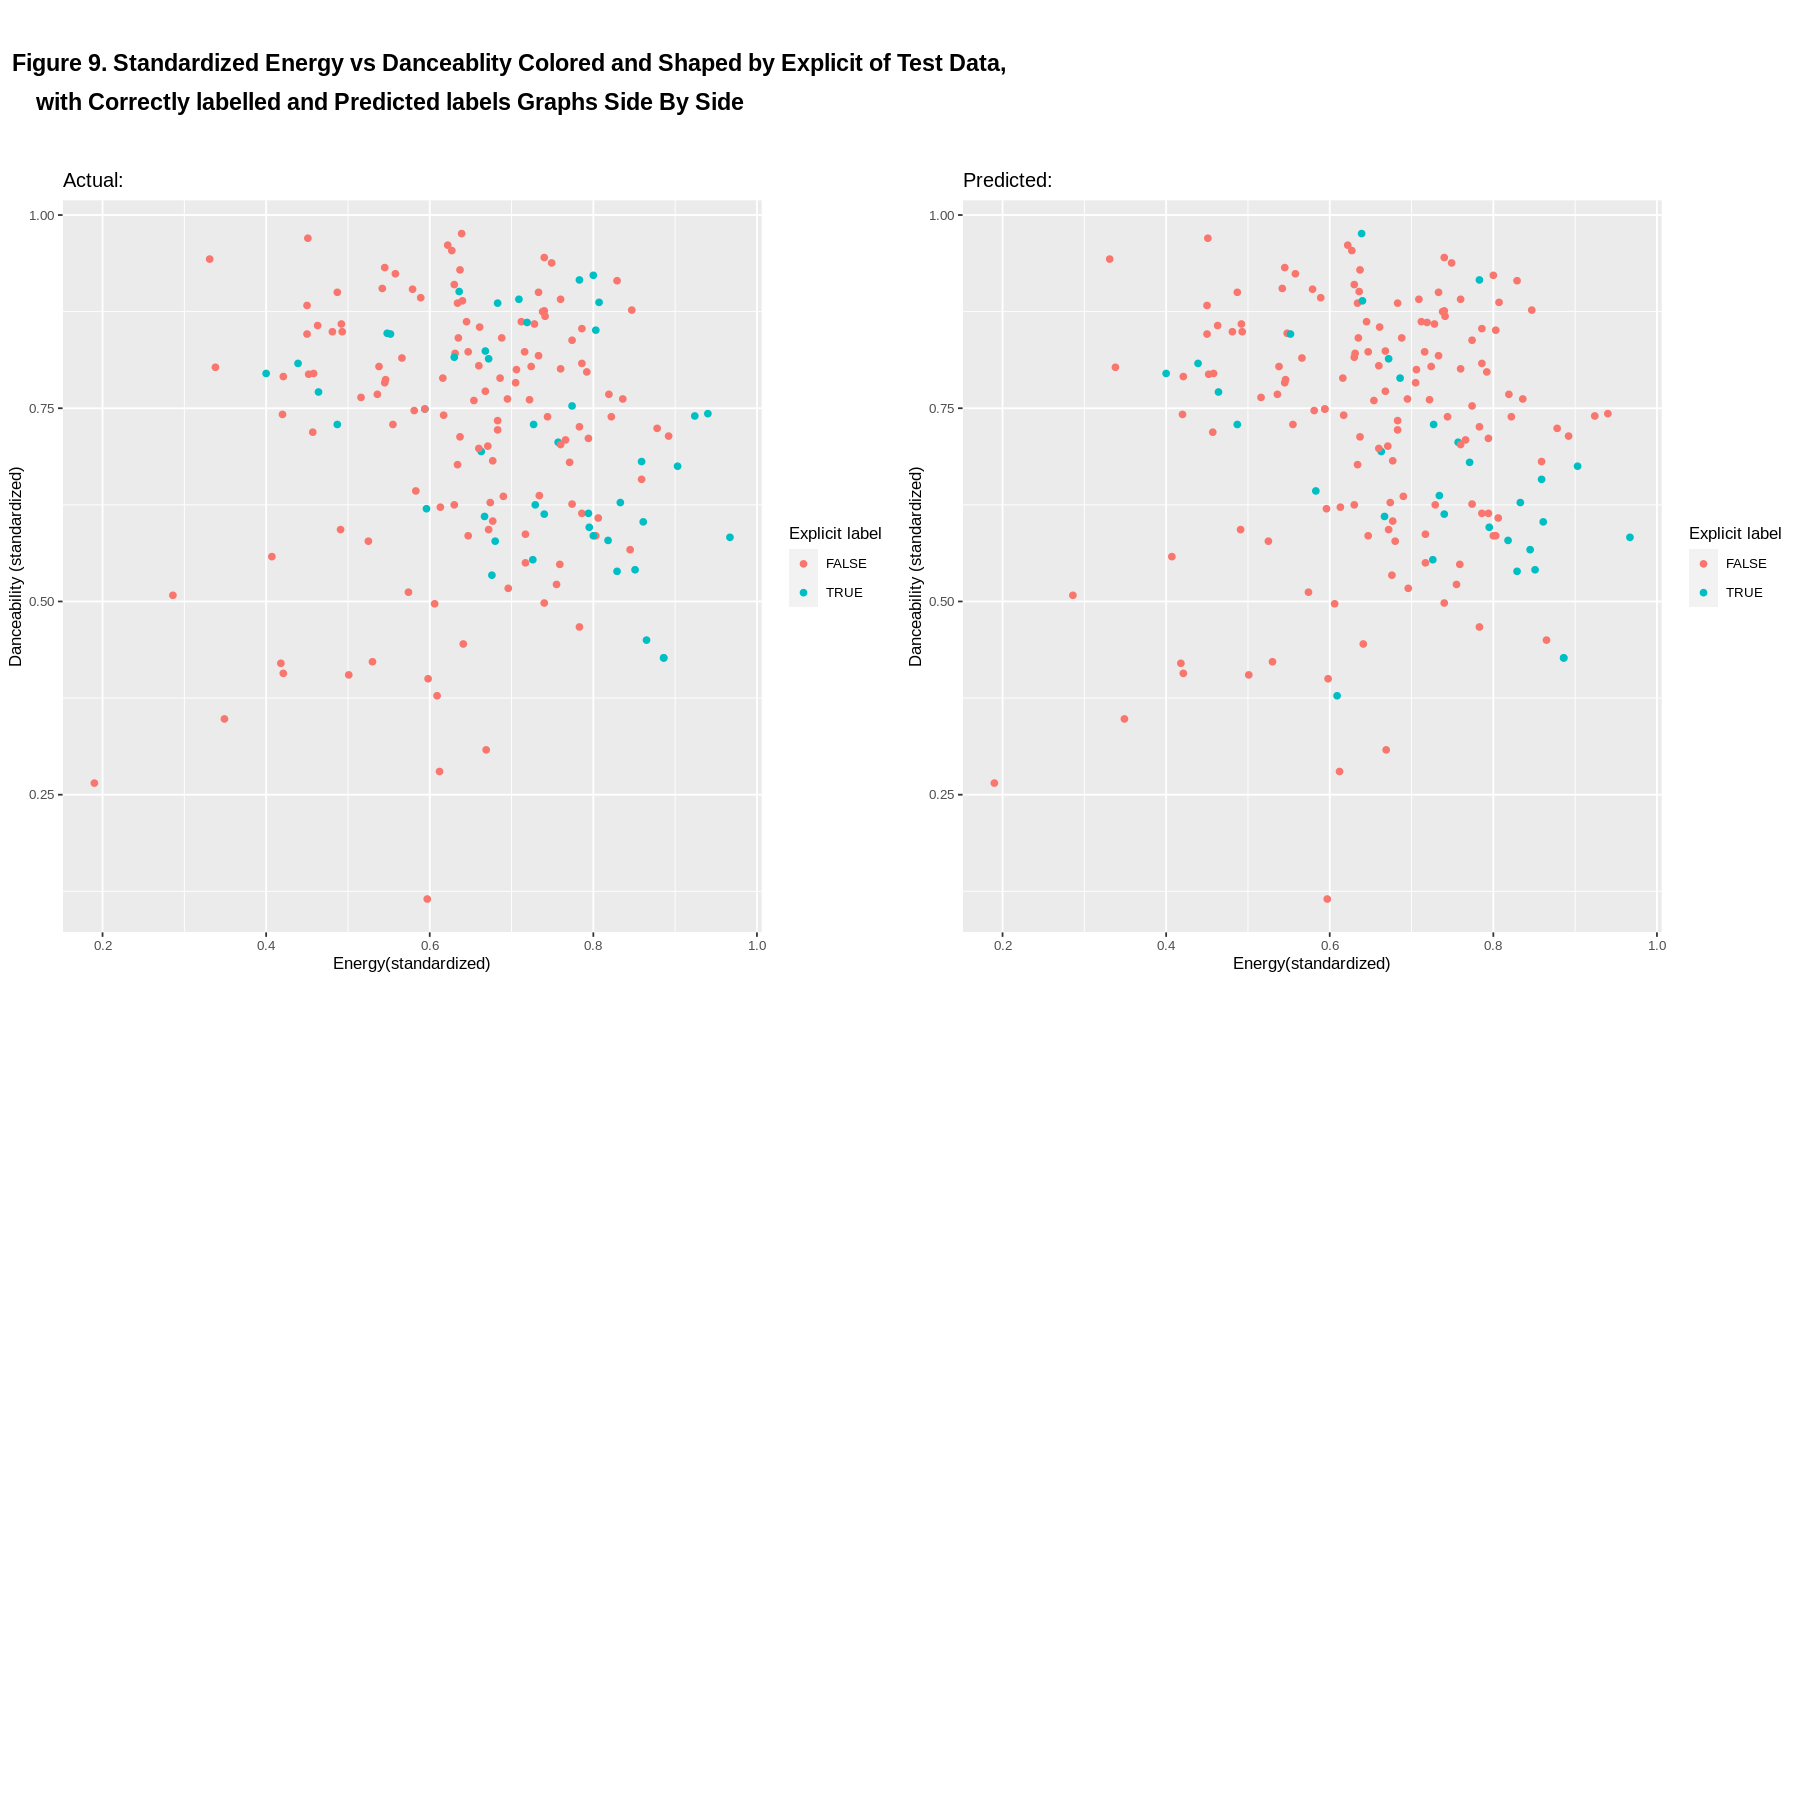

In [196]:
# Standardized Energy vs Danceablity Colored and Shaped by Explicit with Actual and Predicted Graphs Side By Side

correct_D_vs_E_plot <- ggplot(songs_predictions, aes(x = danceability, y = energy, color = explicit)) +
                  geom_point() +
                  labs(x = 'Energy(standardized)', y = 'Danceability (standardized)', color = 'Explicit label') +
                  theme(text = element_text(size = 10)) +
                    ggtitle('Actual:')

predict_D_vs_E_plot <- ggplot(songs_predictions, aes(x = danceability, y = energy, color = .pred_class)) +
                  geom_point() +
                  labs(x = 'Energy(standardized)', y = 'Danceability (standardized)', color = 'Explicit label') +
                  theme(text = element_text(size = 10)) +
                    ggtitle('Predicted:')

D_vs_E_plot <- plot_grid(correct_D_vs_E_plot, predict_D_vs_E_plot, ncol = 2, NULL) 

D_vs_E_title <- ggdraw() + 
    draw_label("Figure 9. Standardized Energy vs Danceablity Colored and Shaped by Explicit of Test Data, \n 
    with Correctly labelled and Predicted labels Graphs Side By Side",
    fontface = 'bold', x = 0, hjust = 0, size = 14, lineheight = 0.7) +
    theme(plot.margin = margin(0, 0, 0, 7))

D_vs_E_plots <- plot_grid(D_vs_E_title, D_vs_E_plot, ncol = 1,rel_heights = c(0.1, 1))

D_vs_E_plots

# Discussion

As observed through Table 5, K = 10 was the most optimal K because it provided the highest estimated accuracy (81.7%) with a low standard error (1.13%). Furthermore, Figure 5 showed that the estimated accuracy changed by only a small amount if we increased or decreased K near K = 10. Moreover, K = 10 did not require an exorbitant computational cost of training. Hence, K = 10 was selected for the classifier.

As assessed through Table 6, the estimated accuracy of the built KNN classifier on the test data was 82.18%, which was higher than the estimated accuracy of the majority classifier (73.5%). The confusion matrix showed that the classifier accurately labelled 23 TRUE and 120 FALSE observations (a total of 143 correctly labelled observations). However, 22 truly TRUE and 9 truly FALSE observations were mislabeled (31 total incorrectly labelled observations). 

Based on this result, we can see that our model had an accuracy of 43% in predicting explicit songs and 93% in predicting unexplicit songs. This was not a very good result and was unexpected because the percentage difference is very large, meaning that the model did a poor job in predicting explicit songs but a fairly great job in predicting unexplicit songs. In other words, the model tends to favor predicting unexplicit songs more.
These findings could lead to spotify potentially developing an algorithm that could properly flag and detect explicit content such that it doesn’t rely on its users to manually flag it themselves. Streamlining user experience should and continues to be one of Spotify’s top priorities and a classification system such as this could be a possible avenue to explore. However, that doesn’t mean that this classification system is perfect either. To reiterate, our algorithm was only ~82% accurate overall. While false positives aren’t too big of an issue, incorrectly classifying explicit songs as non explicit will have unintended consequences if actually applied by the music streaming platform, especially since our classifier was only able to accurately classify explicit songs 42% of the time.

One of the largest limiting factors in our data analysis is the role that genre played in classifying the data. In order to tidy the data set, we had to only filter for songs that only had one assigned genre, ultimately leaving out a notable amount of music that could have changed the results of our classifier. Furthermore, there’s also the fact that a majority of the explicit music was largely confined to one specific genre: hip hop. Because we couldn’t use genre as a KNN predictor due to the fact that it’s a factor and not a numeric value, what could’ve been the largest predictor in explicitness was left out of the classification system, which could explain why our algorithm did such a relatively poor job of classifying explicit music. 

On another methodological limitation, because explicitness is a concept that is almost entirely dependent on the words of a song and less so on the musical elements that make up the rest of the song, it would be important to consider whether or not we looked at the right observations related to the data. This project opens up the possibility to build a classifying system using [Bagging and AdaBoos](https://doi.org/10.1109/bigcomp.2018.00085) that uses the lyrics themselves as the predictors (Chin et al., 2018) as that is ultimately one of if not the most important variable when determining explicitness, though this would require a completely different data set to be analyzed. Considering that Spotify only [recently](https://techcrunch.com/2021/11/18/spotify-finally-rolls-out-real-time-lyrics-to-global-users/) added lyrics to most of its discography (Perez, 2021), this project would need to take some time to develop. To circle back to our original data set, we could potentially extend the scope of our project to include genre as a factor by building a clustering system on the rest of the variables to see if it’s able to properly predict the genre of a song.


## *Work Cited*

Chin, H., Kim, J., Kim, Y., Shin, J., & Yi, M. Y. (2018). Explicit content detection in music lyrics using machine learning. 2018 IEEE International Conference on Big Data and Smart Computing (BigComp). https://doi.org/10.1109/bigcomp.2018.00085

Koverha, M. (2022, May 31). Top hits spotify from 2000-2019. Kaggle. Retrieved June 23, 2022, from https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019


Perez, S. (2021, November 18). Spotify finally rolls out real-time lyrics to global users. TechCrunch. Retrieved June 23, 2022, from https://techcrunch.com/2021/11/18/spotify-finally-rolls-out-real-time-lyrics-to-global-users/

Explicit content. Spotify. (n.d.). Retrieved June 23, 2022, from https://support.spotify.com/us/article/explicit-content/

Timbers, T., Campbell, J., Lee, M., & Peng, R. D. (2022, March 2). Data science. Data Science: A First Introduction. Retrieved June 23, 2022, from https://datasciencebook.ca/ 